In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

2024-11-10 10:41:53.615260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 10:41:53.725367: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /system/conda/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cv2/../../lib64:/opt/amazon/efa/lib:/opt/aws-ofi-nccl/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-11-10 10:41:53.725405: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-11-10 10:41:54.252170: W tensorflow/compiler/xl

In [2]:
# Load CSV file with annotations
csv_file = "/teamspace/studios/this_studio/Dataset_Info.csv"
data = pd.read_csv(csv_file)

# Directory where the images are stored
image_dir = "/teamspace/studios/this_studio/Dataset"


# Define color mappings for each class for visualization
class_map = {
    "Water Bodies": 0,  # Blue or assigned color in masks
    "Vegetation": 1,    # Green or assigned color in masks
    "Buildings": 2      # Red or assigned color in masks
}

In [3]:
def create_mask(image_shape, annotations):
    # Initialize a blank mask with the same height and width as the image, but single channel
    mask = np.zeros(image_shape[:2], dtype=np.uint8)

    # Iterate over each annotation row
    for index, row in annotations.iterrows():
        try:
            # Parse the shape and class attributes
            region_shape = json.loads(row['region_shape_attributes'])
            region_attributes = json.loads(row['region_attributes'])

            # Determine class label from class name
            class_name = region_attributes['Name'].strip()
            label = class_map.get(class_name, 0)  # Default to 0 if class not found

            # Identify the shape type
            shape_name = region_shape['name']

            if shape_name == 'polyline':
                # Extract polyline points
                all_points_x = region_shape['all_points_x']
                all_points_y = region_shape['all_points_y']
                polyline_points = np.array(list(zip(all_points_x, all_points_y)), dtype=np.int32)
                # Draw the polyline on the mask
                cv2.polylines(mask, [polyline_points], isClosed=False, color=label, thickness=2)

            elif shape_name == 'polygon':
                # Extract polygon points
                all_points_x = region_shape['all_points_x']
                all_points_y = region_shape['all_points_y']
                polygon = np.array(list(zip(all_points_x, all_points_y)), dtype=np.int32)
                # Fill the polygon on the mask
                cv2.fillPoly(mask, [polygon], label)

            elif shape_name == 'rect':
                # Extract rectangle attributes
                x = region_shape['x']
                y = region_shape['y']
                width = region_shape['width']
                height = region_shape['height']
                # Draw a filled rectangle on the mask
                cv2.rectangle(mask, (x, y), (x + width, y + height), label, -1)

            elif shape_name == 'circle':
                # Extract circle attributes
                cx = region_shape['cx']
                cy = region_shape['cy']
                r = region_shape['r']
                # Draw a filled circle on the mask
                cv2.circle(mask, (cx, cy), r, label, -1)

            elif shape_name == 'ellipse':
                # Extract ellipse attributes
                cx = region_shape['cx']
                cy = region_shape['cy']
                rx = region_shape['rx']
                ry = region_shape['ry']
                theta = region_shape['theta']  # Angle in radians
                # Draw a filled ellipse on the mask
                cv2.ellipse(mask, (cx, cy), (rx, ry), np.degrees(theta), 0, 360, label, -1)

            else:
                print(f"Unknown shape type: {shape_name}")

        except Exception as e:
            print(f"Error in row {index}: {e}")

    return mask

In [4]:
def load_images_and_masks(data, image_dir):
    images = []
    masks = []

    # Loop through each unique image in the CSV
    for image_filename in data['filename'].unique():
        image_path = os.path.join(image_dir, image_filename)
        if os.path.exists(image_path):
            # Read the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, (512, 512))  # Ensure all images are 512x512

            # Get corresponding annotations for this image
            image_annotations = data[data['filename'] == image_filename]

            # Create mask from annotations
            mask = create_mask(image.shape, image_annotations)

            # Append image and mask to lists
            images.append(image)
            masks.append(mask)

    return np.array(images), np.array(masks)

# Load images and masks
images, masks = load_images_and_masks(data, image_dir)

# Normalize the images and one-hot encode the masks for CNN training
images = images / 255.0  # Normalize image data

# One-hot encode masks to match model output for semantic segmentation
num_classes = len(class_map)
masks_one_hot = tf.keras.utils.to_categorical(masks, num_classes=num_classes)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks_one_hot, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

Training set: (306, 512, 512, 3), (306, 512, 512, 3)
Validation set: (77, 512, 512, 3), (77, 512, 512, 3)


In [9]:
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

def build_fcn_model(input_shape=(512, 512, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsampling)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2), padding='same')(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2), padding='same')(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2), padding='same')(conv3)

    # Decoder (Upsampling)
    up4 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(pool3)
    up4 = layers.Resizing(K.int_shape(conv2)[1], K.int_shape(conv2)[2])(up4)  # Resize to match conv2
    up4 = layers.concatenate([up4, conv2], axis=-1)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up4)

    up5 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv4)
    up5 = layers.Resizing(K.int_shape(conv1)[1], K.int_shape(conv1)[2])(up5)  # Resize to match conv1
    up5 = layers.concatenate([up5, conv1], axis=-1)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up5)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv5)
    model = models.Model(inputs, outputs)

    return model

In [14]:
model = build_fcn_model()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the FCN model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=8)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Save the model
model.save("/teamspace/studios/this_studio/Dataset/FCN_model.h5")

Epoch 1/20
39/39 [==============================] - 474s 12s/step - loss: 0.9474 - accuracy: 0.5115 - val_loss: 0.8218 - val_accuracy: 0.6267
Epoch 2/20
39/39 [==============================] - 472s 12s/step - loss: 0.8488 - accuracy: 0.5554 - val_loss: 0.7868 - val_accuracy: 0.5383
Epoch 3/20
39/39 [==============================] - 474s 12s/step - loss: 0.8281 - accuracy: 0.5635 - val_loss: 0.8066 - val_accuracy: 0.5040
Epoch 4/20
39/39 [==============================] - 473s 12s/step - loss: 0.8148 - accuracy: 0.5799 - val_loss: 0.7944 - val_accuracy: 0.5155
Epoch 5/20
39/39 [==============================] - 473s 12s/step - loss: 0.8168 - accuracy: 0.5931 - val_loss: 0.7909 - val_accuracy: 0.6064
Epoch 6/20
39/39 [==============================] - 473s 12s/step - loss: 0.8184 - accuracy: 0.5770 - val_loss: 0.7612 - val_accuracy: 0.5580
Epoch 7/20
39/39 [==============================] - 473s 12s/step - loss: 0.7998 - accuracy: 0.5865 - val_loss: 0.8121 - val_accuracy: 0.5882
Epoch 

In [15]:
def calculate_iou(y_true, y_pred, num_classes=3):
    ious = []
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    for i in range(num_classes):
        intersection = np.sum((y_true_flat == i) & (y_pred_flat == i))
        union = np.sum((y_true_flat == i) | (y_pred_flat == i))
        iou = intersection / union if union != 0 else 0
        ious.append(iou)
    
    return np.mean(ious)

def calculate_dice(y_true, y_pred, num_classes=3):
    dice_scores = []
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    for i in range(num_classes):
        intersection = np.sum((y_true_flat == i) & (y_pred_flat == i))
        dice = (2 * intersection) / (np.sum(y_true_flat == i) + np.sum(y_pred_flat == i))
        dice_scores.append(dice)
    
    return np.mean(dice_scores)

# Run predictions on the validation set
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_val, axis=-1)

# Calculate IoU (Jaccard), Dice Coefficient, and Pixel Accuracy
iou = calculate_iou(y_true, y_pred, num_classes=num_classes)
dice = calculate_dice(y_true, y_pred, num_classes=num_classes)
pixel_accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
f1 = f1_score(y_true.flatten(), y_pred.flatten(), average="macro")

# Display metrics in a table
metrics_data = {
    "Metric": ["IoU (Jaccard Score)", "Dice Coefficient", "Pixel Accuracy", "F1 Score"],
    "Score": [iou, dice, pixel_accuracy, f1]
}
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

# Display metrics as a table
print("Performance Metrics Table:")
display(metrics_df)

3/3 [==============================] - 31s 9s/step
                Metric     Score
0  IoU (Jaccard Score)  0.282333
1     Dice Coefficient  0.392487
2       Pixel Accuracy  0.601769
3             F1 Score  0.392487
Performance Metrics Table:


,Metric,Score
0,IoU (Jaccard Score),0.282333
1,Dice Coefficient,0.392487
2,Pixel Accuracy,0.601769
3,F1 Score,0.392487


1/1 [==============================] - 0s 457ms/step


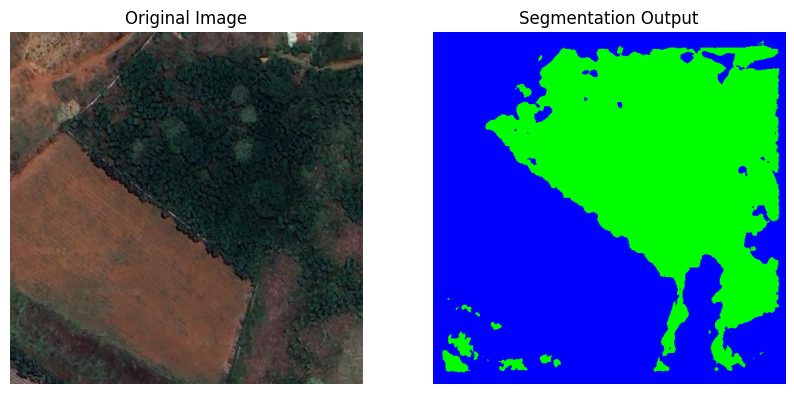

In [17]:
# Define colors for each class
color_map = {
    0: (0, 0, 255),   # Red for Water Bodies
    1: (0, 255, 0),   # Green for Vegetation
    2: (255, 0, 0)    # Blue for Buildings
}

def predict_and_visualize(image, model):
    input_image = cv2.resize(image, (512, 512)) / 255.0
    input_image = np.expand_dims(input_image, axis=0)
    predictions = model.predict(input_image)
    predicted_mask = np.argmax(predictions[0], axis=-1)

    color_overlay = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in color_map.items():
        color_overlay[predicted_mask == class_id] = color

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image")
    axs[1].imshow(color_overlay)
    axs[1].set_title("Segmentation Output")
    for ax in axs:
        ax.axis("off")
    plt.show()

# Test visualization with a test image
test_image_path = "/teamspace/studios/this_studio/Dataset/26.png"
test_image = cv2.imread(test_image_path)
predict_and_visualize(test_image, model)